# Code adapted from
* https://dzlab.github.io/dltips/en/pytorch/torchtext-datasets/ to use custom dataset
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/3%20-%20Faster%20Sentiment%20Analysis.ipynb to use model

In [61]:
CLASS_WEIGHT= 0.21194191606681265

# Class weight var not needed since positive class got swapped and would have a weight of 1 anyways

# Have class weight to compensate for too many positive examples
# Generate bigrams as needed for model

In [30]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [31]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  preprocessing = generate_bigrams)

LABEL = data.LabelField(dtype = torch.float)

# prep data for torchtext and load into data iterators

In [32]:
BATCH_SIZE = 128#64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train, val, test = data.TabularDataset.splits(
    path='./data', train='Train.csv',
    validation='Val.csv', test='Test.csv', format='csv',
    fields=[('text', TEXT),(None, None), ('label', LABEL)],
    skip_header = True)# ignore helpfulness column
    # columns are Text, helpfulness, and rating



In [33]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
    sort_key=lambda x: len(x.text), device = device)

In [34]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train)

# Describe FastText model

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [36]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

#model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [37]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc, rounded_preds

# Train and evaluate have been modified to return the predictions and labels to be used in calculating f1 score

In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    preds=[]
    labels=[]
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, rounded_preds = binary_accuracy(predictions, batch.label)
        preds.extend(rounded_preds.detach().to('cpu').numpy())
        labels.extend(batch.label.detach().to('cpu').numpy())
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [39]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    preds=[]
    labels=[]
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc, rounded_preds = binary_accuracy(predictions, batch.label)
            preds.extend(rounded_preds.detach().to('cpu').numpy())
            labels.extend(batch.label.detach().to('cpu').numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, labels

In [40]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm.notebook import  tqdm

# methods to train model for bayesian optimization and to save model with optimal params

In [84]:
import torch.optim as optim


def train_model(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor([CLASS_WEIGHT])
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    #best_valid_loss = float('inf')
    start_time = time.time()
    for epoch in tqdm(range(N_EPOCHS)):

        

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        
       
        #print('gt: {}'.format(np.unique(v_labels)))
        #print('preds: {}'.format(np.unique(v_preds)))
        
       # if valid_loss < best_valid_loss:
       #     best_valid_loss = valid_loss
       #     torch.save(model.state_dict(), 'sentiment.pt')
        
        #print(f'Epoch: {epoch+1:02}')# | Epoch Time: {epoch_mins}m {epoch_secs}s'
        #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    f1 = f1_score(v_labels, v_preds, average="macro")
    cm = confusion_matrix(v_labels,v_preds)
    #tn, fp, fn, tp = cm.ravel()
    # print(tn,tp)
    print('F1: {}'.format(f1))
    print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
    print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    print(f'Total Train time for {N_EPOCHS} epochs: {epoch_mins}m {epoch_secs}s')
    print("------------------------------------------------------------")
    return f1 


def train_model_save(adam=0,lr=0.001,epochs=5):
    # use base adam if adam <=0.5 otherwise use adamW with weight decay
    model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
    optimizer = optim.Adam(model.parameters(),lr=lr) if adam<=0.5 else optim.AdamW(model.parameters(),lr=lr)
    criterion = nn.BCEWithLogitsLoss() # pos_weight=torch.tensor([CLASS_WEIGHT])
    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = round(epochs)
    start_time = time.time()

    best_valid_f1 = 0

    for epoch in tqdm(range(N_EPOCHS)):

        start_time = time.time()

        train_loss, train_acc, t_preds, t_labels = train(model, train_iter, optimizer, criterion)
        valid_loss, valid_acc, v_preds, v_labels = evaluate(model, val_iter, criterion)
        cm = confusion_matrix(v_labels,v_preds)
        cm2 = confusion_matrix(t_labels, t_preds)
        # tn, fp, fn, tp = cm.ravel()
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        f1 = f1_score(v_labels, v_preds, average="macro")
        print('F1: {}'.format(f1))
        print('Precision: {}'.format(precision_score(v_labels, v_preds, average="macro")))
        print('Recall: {}'.format(recall_score(v_labels, v_preds, average="macro")))
        if f1 > best_valid_f1:
            best_valid_f1 = f1
            torch.save(model.state_dict(), 'sentiment.pt')
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('Confusion Matrix for Train Data')
        ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
        print('-------------------------------------------')
        print('Confusion Matrix for Validation Data')
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    return model
    
    

  0%|          | 0/3 [00:00<?, ?it/s]

F1: 0.7970232008947349
Precision: 0.7986306753114953
Recall: 0.7954481921886816
Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 0.310 | Train Acc: 87.54%
	 Val. Loss: 1.085 |  Val. Acc: 88.36%
F1: 0.7961738073903009
Precision: 0.7965138873696509
Recall: 0.7958352164373921
Epoch: 02 | Epoch Time: 1m 51s
	Train Loss: 0.275 | Train Acc: 89.06%
	 Val. Loss: 1.088 |  Val. Acc: 88.26%
F1: 0.7951959783874178
Precision: 0.7814333769247078
Recall: 0.8122221879311825
Epoch: 03 | Epoch Time: 1m 50s
	Train Loss: 0.267 | Train Acc: 89.38%
	 Val. Loss: 1.297 |  Val. Acc: 87.53%


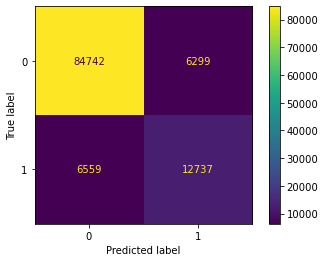

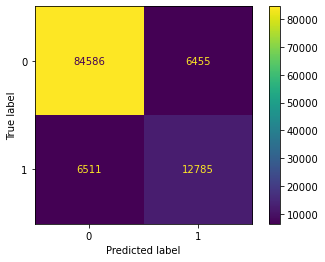

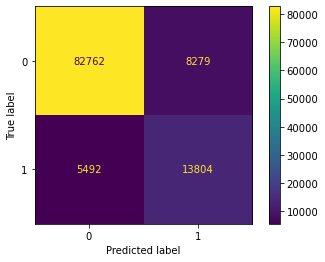

In [69]:
model = train_model_save(lr=0.02,epochs=3)

# perform bayesian optimization

|   iter    |  target   |   adam    |  epochs   |    lr     |
-------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7642539839294475
Precision: 0.7626452453906502
Recall: 0.7659029111166413
Total Train time for 10 epochs: 17m 57s
------------------------------------------------------------
|  1        |  0.7643   |  0.1915   |  9.71     |  0.2189   |


  0%|          | 0/12 [00:00<?, ?it/s]

F1: 0.7638828092574212
Precision: 0.8085928661129491
Recall: 0.735950696329427
Total Train time for 12 epochs: 21m 41s
------------------------------------------------------------
|  2        |  0.7639   |  0.7854   |  11.92    |  0.1363   |


  0%|          | 0/12 [00:00<?, ?it/s]

F1: 0.7356689144247599
Precision: 0.7276761683940383
Recall: 0.7450423925710907
Total Train time for 12 epochs: 21m 53s
------------------------------------------------------------
|  3        |  0.7357   |  0.2765   |  12.23    |  0.4791   |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7794013099826635
Precision: 0.7737867227933583
Recall: 0.7855073913994575
Total Train time for 10 epochs: 18m 21s
------------------------------------------------------------
|  4        |  0.7794   |  0.1847   |  9.721    |  0.2065   |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7735888107620716
Precision: 0.7953842311509771
Recall: 0.7567251389005697
Total Train time for 10 epochs: 18m 11s
------------------------------------------------------------
|  5        |  0.7736   |  0.189    |  9.701    |  0.2333   |


  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.7804431746569245
Precision: 0.7692344593535119
Recall: 0.7938678670812085
Total Train time for 10 epochs: 17m 33s
------------------------------------------------------------
|  6        |  0.7804   |  0.2016   |  9.703    |  0.27     |


  0%|          | 0/2 [00:00<?, ?it/s]

F1: 0.7891570714603537
Precision: 0.7704227418299745
Recall: 0.8151633140139528
Total Train time for 2 epochs: 3m 27s
------------------------------------------------------------
|  7        |  0.7892   |  0.2683   |  2.237    |  0.08882  |


  0%|          | 0/7 [00:00<?, ?it/s]

F1: 0.7793763063630407
Precision: 0.754698964282144
Recall: 0.8220852558174407
Total Train time for 7 epochs: 12m 42s
------------------------------------------------------------
|  8        |  0.7794   |  0.1682   |  6.624    |  0.04813  |


  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.7929023696051797
Precision: 0.7824850890568384
Recall: 0.8050678261396196
Total Train time for 1 epochs: 1m 49s
------------------------------------------------------------
|  9        |  0.7929   |  0.4823   |  1.178    |  0.182    |


  0%|          | 0/3 [00:00<?, ?it/s]

F1: 0.7325166465939607
Precision: 0.7094811770121788
Recall: 0.7957562018897396
Total Train time for 3 epochs: 5m 24s
------------------------------------------------------------
|  10       |  0.7325   |  0.7424   |  3.31     |  0.3939   |


  0%|          | 0/2 [00:00<?, ?it/s]

F1: 0.7881998865353758
Precision: 0.7665476493645673
Recall: 0.8207587868671711
Total Train time for 2 epochs: 3m 38s
------------------------------------------------------------
|  11       |  0.7882   |  0.2339   |  2.226    |  0.07799  |


  0%|          | 0/4 [00:00<?, ?it/s]

F1: 0.7587201632896287
Precision: 0.7403561839903516
Recall: 0.7859489935607165
Total Train time for 4 epochs: 7m 11s
------------------------------------------------------------
|  12       |  0.7587   |  0.6257   |  4.209    |  0.3353   |


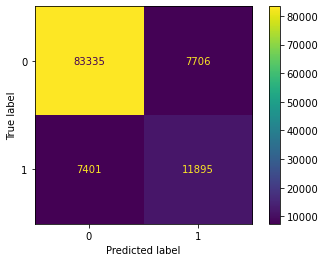

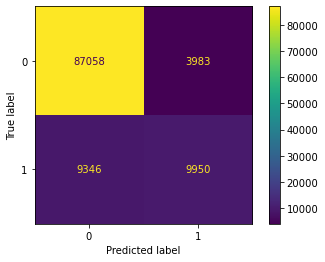

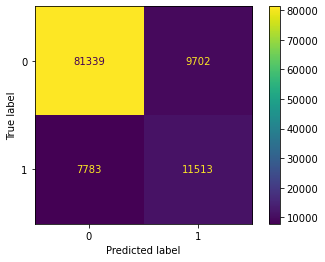

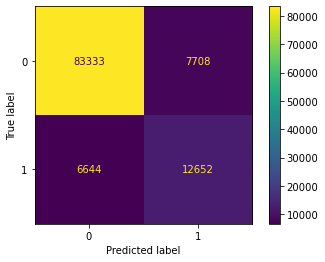

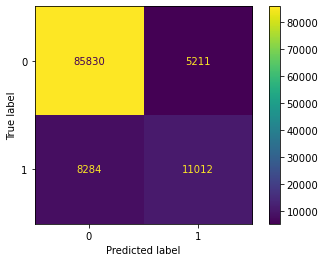

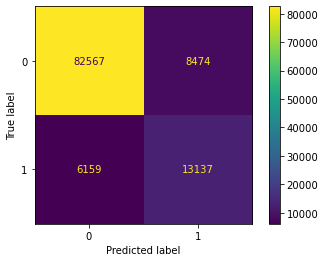

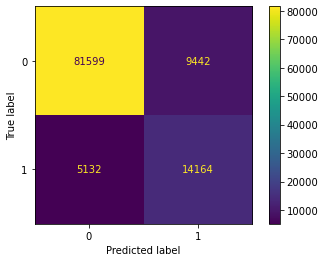

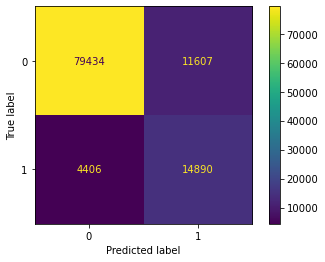

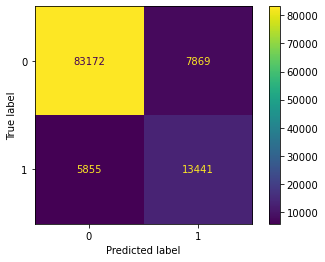

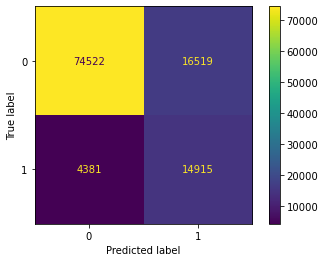

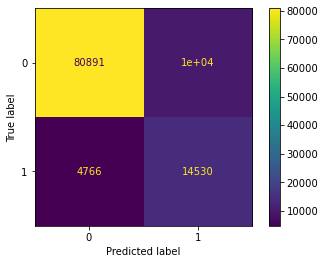

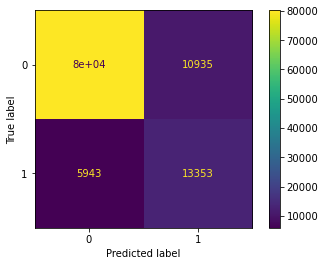

In [79]:
from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'adam':(0,1),'lr': (0.00001, 0.5), 'epochs': (1, 15)}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=SEED,
)
optimizer.maximize(
    init_points=3,
    n_iter=9,
)

In [81]:
bayes_values=[]
bayes_params=[]
for i, res in enumerate(optimizer.res):
    bayes_values.append(res['target'])
    bayes_params.append(f"Iteration {i}")
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7642539839294475, 'params': {'adam': 0.1915194503788923, 'epochs': 9.709522794557646, 'lr': 0.21886949222616717}}
Iteration 1: 
	{'target': 0.7638828092574212, 'params': {'adam': 0.7853585837137692, 'epochs': 11.91966131366325, 'lr': 0.136303576715268}}
Iteration 2: 
	{'target': 0.7356689144247599, 'params': {'adam': 0.2764642551430967, 'epochs': 12.22621048549027, 'lr': 0.47907009544831575}}
Iteration 3: 
	{'target': 0.7794013099826635, 'params': {'adam': 0.18467983199603233, 'epochs': 9.721470217060173, 'lr': 0.20648720525486844}}
Iteration 4: 
	{'target': 0.7735888107620716, 'params': {'adam': 0.18904609454833388, 'epochs': 9.701103037194596, 'lr': 0.2333068672519739}}
Iteration 5: 
	{'target': 0.7804431746569245, 'params': {'adam': 0.20163488781757388, 'epochs': 9.702513829055226, 'lr': 0.27004810173499794}}
Iteration 6: 
	{'target': 0.7891570714603537, 'params': {'adam': 0.26825798565095393, 'epochs': 2.237132465781218, 'lr': 0.08881526334219346}}
Itera

best params: {'target': 0.7929023696051797, 'params': {'adam': 0.4823406418236492, 'epochs': 1.1780935449661807, 'lr': 0.181954129694086}}


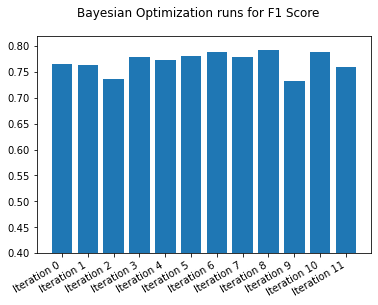

In [82]:
import matplotlib.pyplot as plt
import math
fig, ax = plt.subplots(1, 1)

plt.ylim([0.4, 0.82])
fig.suptitle('Bayesian Optimization runs for F1 Score')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.bar(bayes_params, bayes_values)
print('best params: {}'.format(optimizer.max))

  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.7897979902670665
Precision: 0.7734309347556187
Recall: 0.8112931543513198
Epoch: 01 | Epoch Time: 1m 48s
	Train Loss: 0.319 | Train Acc: 87.30%
	 Val. Loss: 1.259 |  Val. Acc: 87.02%
Confusion Matrix for Train Data
-------------------------------------------
Confusion Matrix for Validation Data


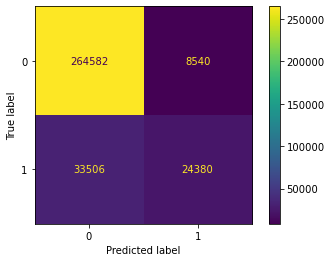

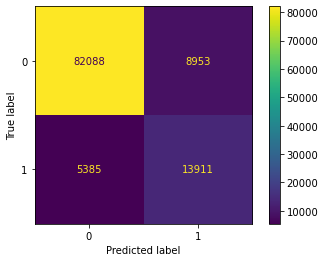

In [85]:
model = train_model_save(adam= optimizer.max['params']['adam'], lr=optimizer.max['params']['lr'],
                 epochs=optimizer.max['params']['epochs'])

# Run on test set

F1: 0.7919272729506811
Precision: 0.7761440518098434
Recall: 0.8123342443205704
Test Loss: 1.239 | Test Acc: 87.20%


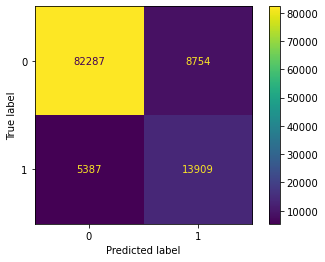

In [86]:
model.load_state_dict(torch.load('sentiment.pt'))
criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc, t_preds, t_labels = evaluate(model, test_iter, criterion)
f1 = f1_score(t_labels, t_preds, average="macro")
print('F1: {}'.format(f1))
print('Precision: {}'.format(precision_score(t_labels, t_preds, average="macro")))
print('Recall: {}'.format(recall_score(t_labels, t_preds, average="macro")))
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
cm = confusion_matrix(t_labels,t_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [87]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return abs(1.0-prediction.item())

# "Real World" generalization
# disclaimer this is acutally correct, pytoch swapped label numbers so a score close to 1 is negative and a score close to 0 is positive
# this is why i changed predict method to be absolute value of 1-prediction

In [90]:
predict_sentiment(model, "this movie sucks hard")

0.0

In [91]:
predict_sentiment(model, "I am so impressed with this item")

0.999999999999967

# Problems
- Some words are not processed correctly: with f1 score tuning sentiments seem to be reversed?
- problem is negative samples in training set. for some reason neutral gives correct generalization

In [ ]:
import pandas as pd
df= pd.read_csv("Tokenized.csv")
df.head()

In [ ]:
df["Prediction"]= df["Text"].map(lambda x:predict_sentiment(model, x))

In [ ]:
df["Scaled_Prediction"]= df.apply(lambda row:(row['Prediction']*row['Helpfulness']), axis=1)

In [ ]:
df.head()

In [ ]:
df.to_csv("results.csv",index=False)

In [ ]:
df.Rating.value_counts()